# Book 4 of 4: Calculatioin and Plotting

### Demonstrating Python Tools through the Calculation of Oceah Heat Content

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Congratulations-You've-Opened-Your-First-Jupyter-Notebook!" data-toc-modified-id="Congratulations-You've-Opened-Your-First-Jupyter-Notebook!-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Congratulations You've Opened Your First Jupyter Notebook!</a></span><ul class="toc-item"><li><span><a href="#Learning-Objectives" data-toc-modified-id="Learning-Objectives-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Learning Objectives</a></span></li><li><span><a href="#What-Is-A-Jupyter-Notebook?" data-toc-modified-id="What-Is-A-Jupyter-Notebook?-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>What Is A Jupyter Notebook?</a></span></li><li><span><a href="#Notebook-User-Interface" data-toc-modified-id="Notebook-User-Interface-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Notebook User Interface</a></span></li><li><span><a href="#What-Is-A-Notebook-Cell?" data-toc-modified-id="What-Is-A-Notebook-Cell?-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>What Is A Notebook Cell?</a></span><ul class="toc-item"><li><span><a href="#Code-Cells" data-toc-modified-id="Code-Cells-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Code Cells</a></span></li><li><span><a href="#Markdown-Cells" data-toc-modified-id="Markdown-Cells-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Markdown Cells</a></span></li><li><span><a href="#Raw-Cells" data-toc-modified-id="Raw-Cells-1.4.3"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>Raw Cells</a></span></li></ul></li><li><span><a href="#Going-Further" data-toc-modified-id="Going-Further-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Going Further</a></span></li></ul></li></ul></div>

## Learning Objectives

- Perform the Ocean-Heat-Content calculation and learn to costumize plots of the results.

----------------

### Previously:

- We imported the Xarray module and loaded our data.
- Check and convert units of temperature and depth.
- We subselected our data to limit the depth of our calculation.

In [ ]:
import xarray as xr

path = '../../../data/'
file = path + 'thetao_Omon_historical_GISS-E2-1-G_r1i1p1f1_gn_185001-187012.nc'

def change_units(ds, variable_str, variable_bounds_str, target_unit_str):
    orig_units = cf.Unit(ds[variable_str].attrs['units'])
    target_units = cf.Unit(target_unit_str)
    variable_in_new_units = xr.apply_ufunc(orig_units.convert, ds[variable_bounds_str], target_units, dask='parallelized', output_dtypes=[ds[variable_bounds_str].dtype])
    return variable_in_new_units


def limit_depth_of_variables(level_bounds, temperature, depth_limit): 
    level_bounds_limited = level_bounds.where(level_bounds < depth_limit, depth_limit)
    delta_level = abs(level_bounds_limited[:, 1] - level_bounds_limited[:, 0])
    
    delta_level_limited = delta_level.where(delta_level != 0, drop = True)
    temperature_limited = temperature.where(delta_level != 0, drop = True)
    
    return delta_level_limited, temperature_limited



ds = xr.open_dataset(file, chunks = {'time': 16})

level_bounds_in_m = change_units(ds, 'lev', 'lev_bnds', 'm')
temperature_in_degK = change_units(ds, 'thetao', 'thetao', 'degK') 

delta_level_limited, temperature_limited = limit_depth_of_variables(level_bounds_in_m, temperature_in_degK, 50)

------------

### 1 -- now we can do some math and actually CALCULATE THE OCEAN HEAT CONTENT!

The formula for this is:

$$ H = \rho  C \int_{0}^{z}T(z) dz $$

Where H is ocean heat content, the value we are trying to calculate,

$\rho$ is the density of sea water, $1026$ $kg/m^3$,

$C$ is the specific heat of sea water, $3990$ $J/(kg K)$,

$z$ is the depth limit of the calculation in meters,

and $T$ is the temperature at each depth in degrees Kelvin.

# <span style="color:red"> Task 1 -  Write a function to calculate Ocean Heat Content</span>
Write a function for the ocean heat content equation in the code cell block below:

In [ ]:
# Your code here

This is my function:

In [24]:
def calc_ocean_heat(delta_level, temperature):
    rho = 1026 #kg/m^3
    c_p = 3990 #J/(kg K)
    weighted_temperature = delta_level * temperature
    heat = weighted_temperature.sum(dim="lev")*rho*c_p
    return heat

In [25]:
heat = calc_ocean_heat(delta_level_limited, temperature_limited)
heat

<xarray.DataArray (time: 252, lat: 180, lon: 288)>
dask.array<shape=(252, 180, 288), dtype=float64, chunksize=(8, 180, 288)>
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 1870-12-16 12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

----------------

### 2 -- Bringing it all together

Let's combine all of our helper functions into one routine that opens the file, checks/converts units, limits depth, and performs the calculation. 

In a function when an input is specified as `a=SomeValue` that means that the input `a` is optional, and if a is not provided the value `SomeValue` is used. In the below function this is used to specify a standard depth limit for the heat calculation.

In [26]:
def calc_heat_from_file(file, depth_limit=275):
    ds = xr.open_dataset(file)
    
    level_bounds_in_m = change_units(ds, 'lev', 'lev_bnds', 'm')
    temperature_in_degK = change_units(ds, 'thetao', 'thetao', 'degK') 
    
    delta_level_limited, temperature_limited = limit_depth_of_variables(level_bounds_in_m, temperature_in_degK, depth_limit)
    
    heat = calc_ocean_heat(delta_level_limited, temperature_limited)
    heat.attrs['units'] = 'Joules/K'
    return heat

In [27]:
heat = calc_heat_from_file(file)
heat

<xarray.DataArray (time: 252, lat: 180, lon: 288)>
dask.array<shape=(252, 180, 288), dtype=float64, chunksize=(252, 180, 288)>
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 1870-12-16 12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

-------------

### 3 --  Plotting

Congratulations you calculated the ocean heat content. You probably want to look at your data or produce some figures to communicate your findings. The next section of the notebook is all about plotting methods.

First, if you are working in a Jupyter notebook (which you are), you need to specify to display plots under the code cell block. To do that you need the following command:

In [28]:
%matplotlib inline

Xarray has built-in plotting functionality called by `.plot()` that will intelligently pick the best plotting method for a DataSet.

(array([4589424.,  170604.,   93439.,   74735.,   66431.,   41587.,
          47124.,   49896.,   65144., 7865296.]),
 array([0.00000000e+00, 3.37712998e+10, 6.75425995e+10, 1.01313899e+11,
        1.35085199e+11, 1.68856499e+11, 2.02627799e+11, 2.36399098e+11,
        2.70170398e+11, 3.03941698e+11, 3.37712998e+11]),
 <a list of 10 Patch objects>)

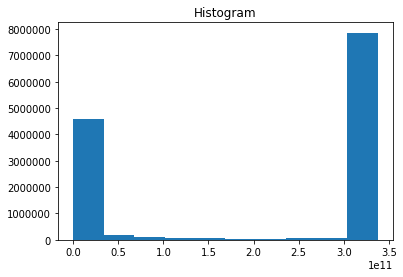

In [29]:
heat.plot()

The above method produced a histogram of heat values because you have data in 2 spatial dimensions and 1 in time. 

Let's one point in time using Xarray's `isel` method. `isel` refers to index-select and allows you to name the dimension in which you are subselecting. Read more about indexing and selecting data from an Xarray DataSet [here](http://xarray.pydata.org/en/stable/indexing.html).

In [30]:
heat_time0 = heat.isel(time=0)
heat_time0

<xarray.DataArray (lat: 180, lon: 288)>
dask.array<shape=(180, 288), dtype=float64, chunksize=(180, 288)>
Coordinates:
    time     object 1850-01-16 12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

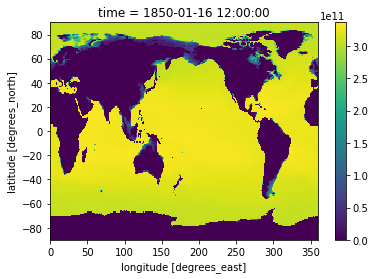

In [31]:
heat_time0.plot()

Reminder: `isel` is in contrast to `.sel` which allows you to select data by value.

Below we look for data between January and February in the year 1860:

In [74]:
heat_Jan_1860 = heat.sel(time=slice('1860-01-01','1860-02-01')).squeeze('time')
heat_Jan_1860

<xarray.DataArray (lat: 180, lon: 288)>
dask.array<shape=(180, 288), dtype=float64, chunksize=(180, 288)>
Coordinates:
    time     object 1860-01-16 12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

Use the `cmap` to change your color map. I will use a different color map for each example to demonstrate some options. Be sure to follow [guidelines](https://seaborn.pydata.org/tutorial/color_palettes.html) about selecting good colormaps. 

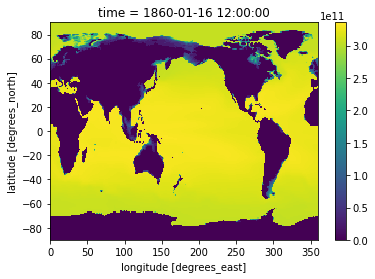

In [75]:
heat_Jan_1860.plot(cmap='Blues')

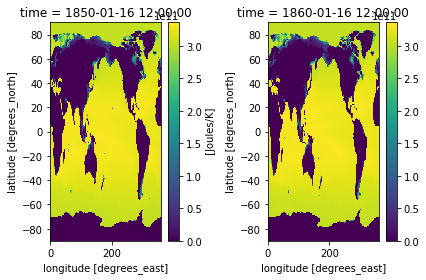

In [76]:
fig, axes = plt.subplots(ncols=2)
heat_time0.plot(ax=axes[0])
heat_Jan_1860.plot(ax=axes[1])
plt.tight_layout()

Use the `cmap` to change your color map. I will use a different color map for each example to demonstrate some options. Be sure to follow [guidelines](https://seaborn.pydata.org/tutorial/color_palettes.html) about selecting good colormaps. 

Xarray is intelligent about attributes in plotting. If we add units, our colorbar will automatically be labeled. 

Let's specify a units attribute for our heat values:

Perhaps you want the contour plot to have discrete levels. You can do this by specifying the number of levels like-so:

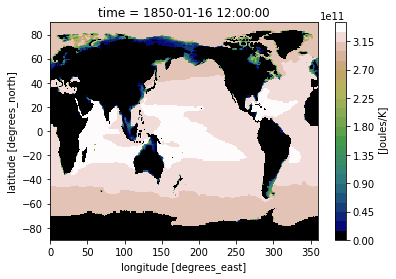

In [37]:
heat_time0.plot(cmap='gist_earth', levels=30)

Or you can specify the space and color of each level:

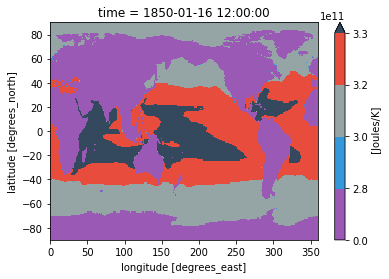

In [39]:
levels = [0, 2.8e11, 3e11, 3.2e11, 3.3e11]
level_colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
heat_time0.plot(levels=levels, colors=level_colors)

If you want to plot multiple plots on the same colorbar, it is useful to normalize your colorbar. Some options are matplotlib's `colors.Normalize`, `colors.BoundaryNorm`, and `colors.LogNorm` which allows you to put your data on a logarithmic color bar. Read about colormap normalization [here](https://matplotlib.org/users/colormapnorms.html). 

In [42]:
from matplotlib import colors

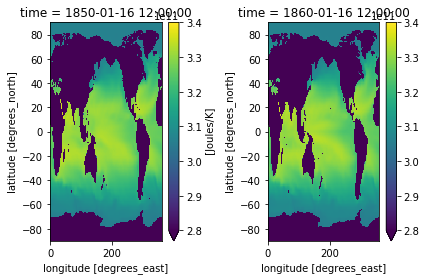

In [77]:
cmin = 2.8e11
cmax = 3.4e11
cnorm = colors.Normalize(cmin, cmax)

fig, axes = plt.subplots(ncols=2)
heat_time0.plot(ax=axes[0], norm=cnorm)
heat_Jan_1860.plot(ax=axes[1], norm=cnorm)
plt.tight_layout()

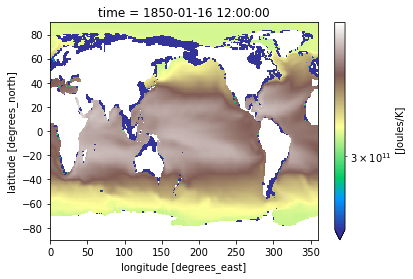

In [64]:
cmin = 2.8e11
cmax = 3.4e11
cnorm = colors.LogNorm(cmin, cmax)

heat_time0.plot(norm=cnorm, cmap='terrain')

Maybe you want to plot the difference between two time stamps and pick a diverging colormap for positive and negative differences.

In [80]:
heat_diff = heat_time0 - heat_Jan_1860
heat_diff.attrs['units'] = 'Joules/K'
heat_diff

<xarray.DataArray (lat: 180, lon: 288)>
dask.array<shape=(180, 288), dtype=float64, chunksize=(180, 288)>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
Attributes:
    units:    Joules/K

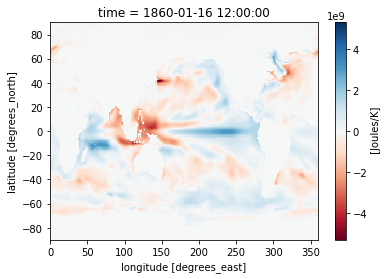

In [54]:
heat_diff.plot(cmap='RdBu')

Wouldn't it be nice to see land borders on the above plot?

We can use [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) for this!

In [66]:
import cartopy.crs as ccrs

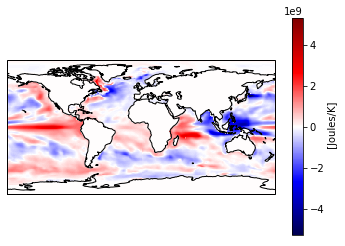

In [90]:
ax = plt.axes(projection=ccrs.PlateCarree())
heat_diff.plot(ax=ax, cmap='seismic')
ax.set_global() 
ax.coastlines()

Or you can use different projections!

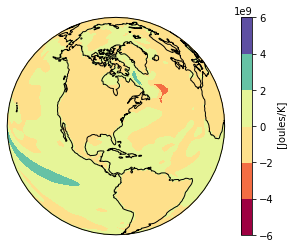

In [87]:
ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
heat_diff.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cmap='Spectral')
ax.set_global()
ax.coastlines()

***TO DO

add axis labels
add titles
adjust colorbar label, and location

## Going further:
- Reading on Matplotlib:
- Reading on Cartopy:

<div class="alert alert-block alert-success">
  <p>Previous: <a href="03_units.ipynb">Units</a></p>
</div>